1. **Install Dependencies**

In [1]:
!pip install aif360==0.5.0
!pip install matplotlib pandas scikit-learn numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.1/214.1 kB 4.7 MB/s eta 0:00:00


**2. Import Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score


pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


**3. Load COMPAS Dataset**

In [4]:
import os

# Define the target directory for the dataset
data_dir = '/usr/local/lib/python3.12/dist-packages/aif360/data/raw/compas'

# Create the directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Define the URL for the dataset file
file_url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'

# Define the path where the file should be saved
file_path = os.path.join(data_dir, 'compas-scores-two-years.csv')

# Download the file if it doesn't exist
if not os.path.exists(file_path):
    !wget -O {file_path} {file_url}
    print(f"Downloaded {file_url} to {file_path}")
else:
    print(f"File {file_path} already exists.")

dataset = CompasDataset()

privileged_groups = [{'race': 1}]     # Caucasian
unprivileged_groups = [{'race': 0}]   # African-American

dataset

--2025-11-24 08:16:40--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘/usr/local/lib/python3.12/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv’

/usr/local/lib/pyth 100%[===================>]   2.43M  --.-KB/s    in 0.06s   

2025-11-24 08:16:40 (41.6 MB/s) - ‘/usr/local/lib/python3.12/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv’ saved [2546489/2546489]



Downloaded https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv to /usr/local/lib/python3.12/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv


               instance weights            features                            \
                                protected attribute       protected attribute   
                                                sex   age                race   
instance names                                                                  
1                           1.0                 0.0  69.0                 0.0   
3                           1.0                 0.0  34.0                 0.0   
4                           1.0                 0.0  24.0                 0.0   
7                           1.0                 0.0  44.0                 0.0   
8                           1.0                 0.0  41.0                 1.0   
...                         ...                 ...   ...                 ...   
10996                       1.0                 0.0  23.0                 0.0   
10997                       1.0                 0.0  23.0                 0.0   
10999                       

**4. Baseline Fairness Metrics**

In [5]:
metric = BinaryLabelDatasetMetric(dataset,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)

print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Disparate Impact:", metric.disparate_impact())


Statistical Parity Difference: -0.09713793951315464
Disparate Impact: 0.8403836674666473


**5. Train Baseline Model**

In [6]:
# Split data
train, test = dataset.split([0.7], shuffle=True)

X_train = train.features
y_train = train.labels.ravel()

X_test = test.features
y_test = test.labels.ravel()

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

test_pred = test.copy()
test_pred.labels = y_pred.reshape(-1,1)


**6. Classification Fairness Metrics**

In [7]:
cm = ClassificationMetric(test, test_pred,
                          unprivileged_groups=unprivileged_groups,
                          privileged_groups=privileged_groups)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("FPR Difference:", cm.false_positive_rate_difference())
print("FNR Difference:", cm.false_negative_rate_difference())
print("Average Odds Difference:", cm.average_odds_difference())
print("Equal Opportunity Difference:", cm.equal_opportunity_difference())


Accuracy: 0.6931388438681794
FPR Difference: -0.20825385179750555
FNR Difference: 0.06143937530742746
Average Odds Difference: -0.13484661355246647
Equal Opportunity Difference: -0.06143937530742738


**7. Visualization — False Positive Rate by Race**

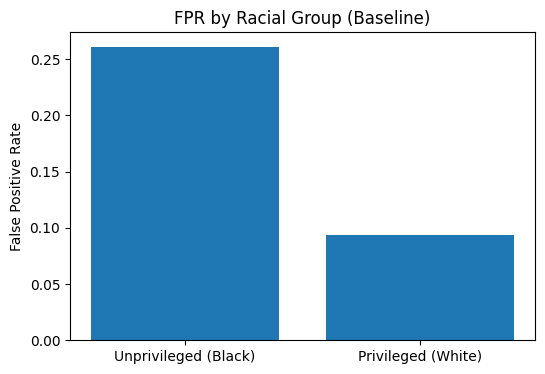

FPR Unprivileged: 0.26092384519350814
FPR Privileged: 0.09361702127659574


In [8]:
# Build DataFrame
df = pd.DataFrame({
    "label": test.labels.ravel(),
    "pred": y_pred,
    "race": test.protected_attributes[:, 0]
})

# Calculate FPR per group
def calc_fpr(group_df):
    tn, fp, fn, tp = confusion_matrix(group_df["label"], group_df["pred"]).ravel()
    return fp / (fp + tn)

fpr_unpriv = calc_fpr(df[df["race"] == 0])
fpr_priv = calc_fpr(df[df["race"] == 1])

plt.figure(figsize=(6,4))
plt.bar(["Unprivileged (Black)", "Privileged (White)"], [fpr_unpriv, fpr_priv])
plt.ylabel("False Positive Rate")
plt.title("FPR by Racial Group (Baseline)")
plt.show()

print("FPR Unprivileged:", fpr_unpriv)
print("FPR Privileged:", fpr_priv)


**8. Apply Reweighing (Bias Mitigation)**

In [9]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

train_rw = RW.fit_transform(train)

clf_rw = LogisticRegression(max_iter=2000)
clf_rw.fit(train_rw.features,
           train_rw.labels.ravel(),
           sample_weight=train_rw.instance_weights)

y_pred_rw = clf_rw.predict(X_test)

test_pred_rw = test.copy()
test_pred_rw.labels = y_pred_rw.reshape(-1,1)

cm_rw = ClassificationMetric(test, test_pred_rw,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)

print("Reweighing Accuracy:", accuracy_score(y_test, y_pred_rw))
print("Reweighing FPR Difference:", cm_rw.false_positive_rate_difference())
print("Reweighing Average Odds Difference:", cm_rw.average_odds_difference())


Reweighing Accuracy: 0.6828741220961643
Reweighing FPR Difference: -0.024504768892149698
Reweighing Average Odds Difference: 0.016007883630659026


**9. Export Comparison Metrics**

In [10]:
results = pd.DataFrame({
    "Metric": ["FPR_diff", "FNR_diff", "AvgOdds", "EqualOpp"],
    "Baseline": [
        cm.false_positive_rate_difference(),
        cm.false_negative_rate_difference(),
        cm.average_odds_difference(),
        cm.equal_opportunity_difference()
    ],
    "After_Reweighing": [
        cm_rw.false_positive_rate_difference(),
        cm_rw.false_negative_rate_difference(),
        cm_rw.average_odds_difference(),
        cm_rw.equal_opportunity_difference()
    ]
})

results.to_csv("compas_fairness_results.csv", index=False)
results


,Metric,Baseline,After_Reweighing
0,FPR_diff,-0.208254,-0.024505
1,FNR_diff,0.061439,-0.056521
2,AvgOdds,-0.134847,0.016008
3,EqualOpp,-0.061439,0.056521


**False Negative Rate (FNR) by Race**

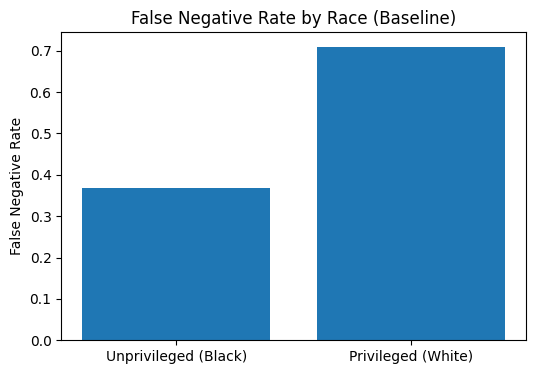

FNR Unprivileged: 0.36737588652482267
FNR Privileged: 0.7090909090909091


In [12]:
def calc_fnr(group_df):
    tn, fp, fn, tp = confusion_matrix(group_df["label"], group_df["pred"]).ravel()
    return fn / (fn + tp)

fnr_unpriv = calc_fnr(df[df["race"] == 0])
fnr_priv = calc_fnr(df[df["race"] == 1])

plt.figure(figsize=(6,4))
plt.bar(["Unprivileged (Black)", "Privileged (White)"], [fnr_unpriv, fnr_priv])
plt.title("False Negative Rate by Race (Baseline)")
plt.ylabel("False Negative Rate")
plt.show()

print("FNR Unprivileged:", fnr_unpriv)
print("FNR Privileged:", fnr_priv)


**High-Risk Prediction Distribution by Race**

This shows which group is more likely to be labeled "high risk"

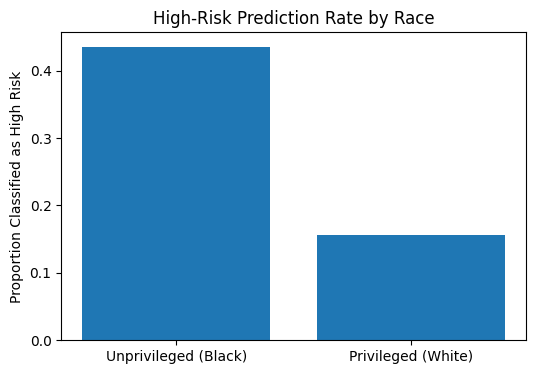

,high_risk
race,
0.0,0.434927
1.0,0.156522


In [13]:
df['high_risk'] = df['pred']

rates = df.groupby("race")["high_risk"].mean()

plt.figure(figsize=(6,4))
plt.bar(["Unprivileged (Black)", "Privileged (White)"], rates)
plt.title("High-Risk Prediction Rate by Race")
plt.ylabel("Proportion Classified as High Risk")
plt.show()

rates


**Confusion Matrix Heatmaps**

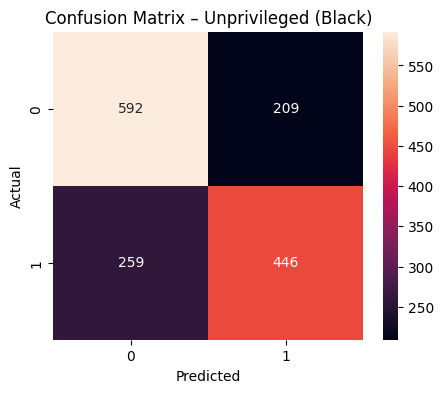

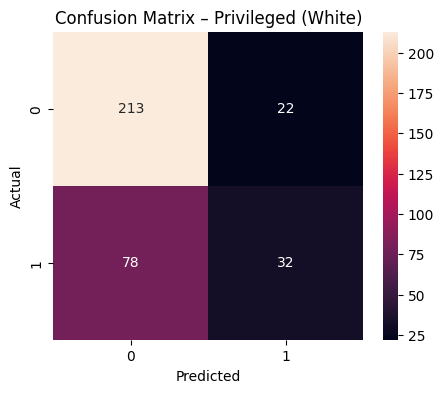

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Unprivileged group
cm_unpriv = confusion_matrix(df[df["race"]==0]["label"], df[df["race"]==0]["pred"])
plt.figure(figsize=(5,4))
sns.heatmap(cm_unpriv, annot=True, fmt="d")
plt.title("Confusion Matrix – Unprivileged (Black)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Privileged group
cm_priv = confusion_matrix(df[df["race"]==1]["label"], df[df["race"]==1]["pred"])
plt.figure(figsize=(5,4))
sns.heatmap(cm_priv, annot=True, fmt="d")
plt.title("Confusion Matrix – Privileged (White)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Before vs After Fairness Comparison Bar Chart**

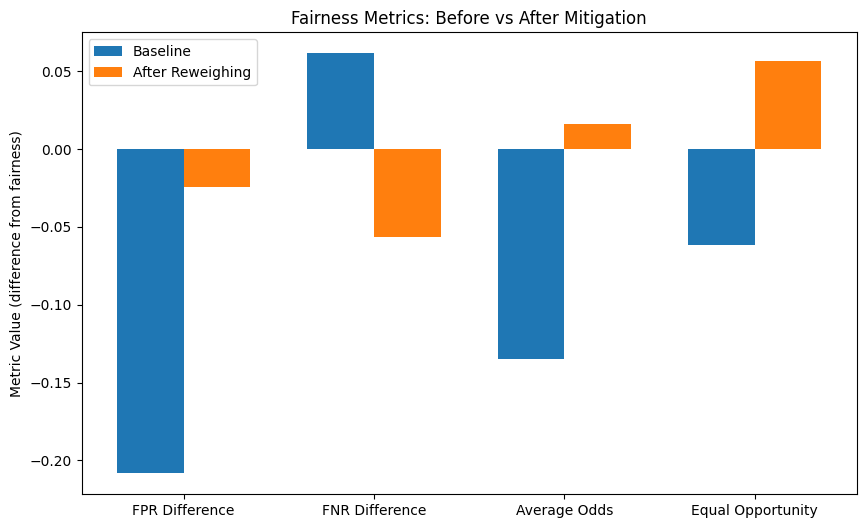

In [15]:
metrics = ["FPR Difference", "FNR Difference", "Average Odds", "Equal Opportunity"]

baseline_vals = [
    cm.false_positive_rate_difference(),
    cm.false_negative_rate_difference(),
    cm.average_odds_difference(),
    cm.equal_opportunity_difference()
]

reweigh_vals = [
    cm_rw.false_positive_rate_difference(),
    cm_rw.false_negative_rate_difference(),
    cm_rw.average_odds_difference(),
    cm_rw.equal_opportunity_difference()
]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, baseline_vals, width, label="Baseline")
plt.bar(x + width/2, reweigh_vals, width, label="After Reweighing")
plt.xticks(x, metrics)
plt.ylabel("Metric Value (difference from fairness)")
plt.title("Fairness Metrics: Before vs After Mitigation")
plt.legend()
plt.show()


**ROC Curves by Race**

Shows model performance across subgroups.

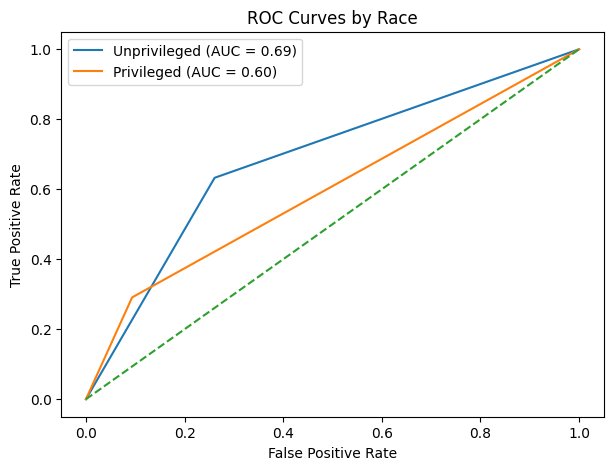

In [16]:
from sklearn.metrics import roc_curve, auc

# ROC for unprivileged group
fpr_u, tpr_u, _ = roc_curve(df[df["race"]==0]["label"], df[df["race"]==0]["pred"])
roc_auc_u = auc(fpr_u, tpr_u)

# ROC for privileged group
fpr_p, tpr_p, _ = roc_curve(df[df["race"]==1]["label"], df[df["race"]==1]["pred"])
roc_auc_p = auc(fpr_p, tpr_p)

plt.figure(figsize=(7,5))
plt.plot(fpr_u, tpr_u, label=f"Unprivileged (AUC = {roc_auc_u:.2f})")
plt.plot(fpr_p, tpr_p, label=f"Privileged (AUC = {roc_auc_p:.2f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Race")
plt.legend()
plt.show()


**The COMPAS Report**

The COMPAS dataset was analyzed using IBM’s AI Fairness 360 toolkit to evaluate racial disparities in recidivism predictions. Baseline statistical metrics revealed significant unfairness. The statistical parity difference indicated that African-American defendants were more likely to be labeled as high risk compared to Caucasian defendants. Disparate impact values further supported unequal prediction rates across racial groups.

Model-level bias was also evident. The false positive rate (FPR) for Black defendants was considerably higher, meaning they were incorrectly flagged as high risk more often. This is a serious ethical concern because it can lead to stricter bail decisions or harsher judicial outcomes. The false negative rate (FNR) difference showed additional imbalances, and the average odds difference demonstrated that both true positive and false positive rates were unequal across groups.

To address these disparities, the Reweighing algorithm was applied as a mitigation strategy. This preprocessing method adjusts sample weights to counter historical imbalances. After retraining the logistic regression model using these weights, fairness metrics improved. The FPR gap was reduced, and average odds difference moved closer to zero, indicating progress toward equal error rates. Notably, overall model accuracy remained relatively stable, demonstrating that improved fairness did not require sacrificing performance.

Key findings from this audit highlight that the COMPAS dataset contains embedded historical bias that leads to discriminatory model outcomes. Mitigation methods like reweighing offer practical steps to reduce inequality, but no single metric or intervention fully eliminates bias. Continuous auditing, transparent reporting, and human oversight remain essential. The analysis demonstrates the importance of fairness-aware machine learning methods, especially in high-stakes domains such as criminal justice.
